# Cyclical Learning Rate

1. Briefly explain the concept behind the cyclical learning rate
2. Use the "LR range test" to choose a good base and max learning rate for the cyclical leraning rate

## Cyclical Learning Rate Concept

In his paper [1], Leslie N. Smith introduced the concept of cyclical learning rates, that is, learning rates that periodically alternative between a user-specified minimum and maximum learning rate. 

Varying the learning rate between between specified bounds, as implemented by Smith, is cheaper to compute than the nowadays popular approach using adaptive learning rates. Note that adaptive learning rate can also be combined with the concept of cyclical learning rates.

The idea behind cyclical learning rates is that while increasing the learning rate can be harmful short term it can be beneficial in the long run. Concretely, the three methods introduced by Smith (and implemented in this notebook) are

- `triangular`: The base approach, varying between a lower and an upper bound, as illustrated in the figure below
- `triangular2`: Same as triangular, but learning rate difference is cut in half at the end of each cycle. This means the learning rate difference drops after each cycle
-- `exp_range`: The learning rate varies between the minimum and maximum boundaries and each boundary value declines by an exponential factor of $gamma^{iteration}$


{insert figure}


### References


- [1] Smith, Leslie N. “[Cyclical learning rates for training neural networks](https://ieeexplore.ieee.org/abstract/document/7926641/).” Applications of Computer Vision (WACV), 2017 IEEE Winter Conference on. IEEE, 2017.

Following the description in the paper, the different cyclical learning rates are very simple to implement, as shown below:

In [4]:
import numpy as np


def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.001,
                           max_lr=0.006,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr

To ensure that the learning rate works as intended, let us plot the learning rate variation for a dry run. Note that `batch_step` is a variable that tracks the total number of times a model has been updated. For instance, if we run the training loop over 5 epochs (5 passes over the training set), where each epoch is split into 100 batches, then we have a `batch_step` count of 5 * 100 = 500 at the end of the training. 

In [5]:
num_epochs = 50
num_train = 50000
batch_size = 100
iter_per_ep = num_train // batch_size

**Triangular**

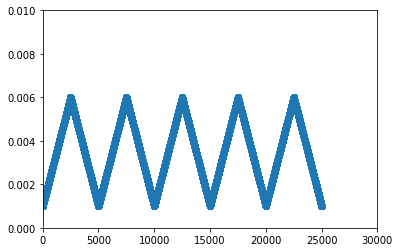

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*5)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

As we can see above, with a batchsize of 100 and for a training set of 50,000 training example, we have 50,000=500 iterations per epoch. With a cycle length of 5*iterations_per_epoch=25,000, the learning rate reaches the base_lr every 5 epochs, which is equal to 25,000 batch updates. The stepsize is defined as cycle/2, i.e., 25,000/2 = 12,500 batch updates.

**Triangular2**

The `triangular2` learning rate is similar to the `triangular` learning rate but cuts the max. learning rate in halve after each cycle.

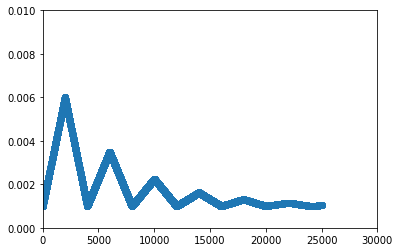

In [7]:
collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='triangular2')
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

**Exp_range**

The `exp_range` option adds an additional hyperparameter, `gamma` to decay the learning rate exponentially.

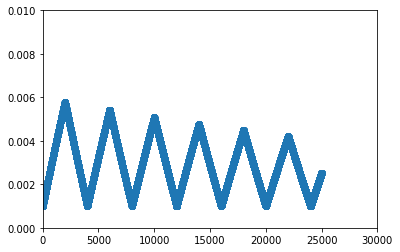

In [8]:
collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='exp_range',
                                        gamma=0.99998)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

## LR Range Test

The LR range test is a simple heuristic that is also described in Smith's paper. Essentially, it's a quick-and-dirty approach to find good values for the `base_lr` and `max_lr` (hyperparameters of the cyclical learning rate).

It works as follows:

We run the training for 5-10 epochs and increase the learning rate linearly up to an upper bound. We select the cut-off where the (train or validation) accuracy starts improving as the base_lr for the cyclical learning rate. The max_lr for the cyclical learning rate is determined in a similar manner, by choosing the cut-off value where the accuracy improvements stop, decrease, or widely fluctuate.

Note that we can use the `cyclical_learning_rate` function to compute the learning rates for the increasing interval by setting `step_size=num_epochs*iter_per_ep`:

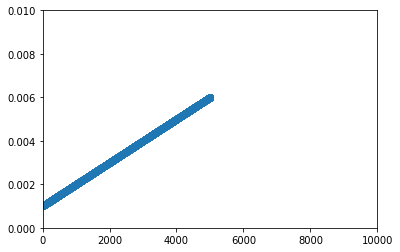

In [9]:
num_epochs = 10

batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=num_epochs*iter_per_ep)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()